# L1 - Градиентый спуск и линейные модели

### 1. Линейные модели

Пусть есть обучающая выборка $\{x_i\}_{i=1}^{\mathcal{l}} \subset \mathbb{R}^{n}$, при этом каждому объекту в соответсвие поставлена метка класса $y_{i} \in \{-1, +1\}$. Мы предполагаем, что в пространтсве $\mathbb{R}^{n}$ существует гиперплоскость, которая относительно некоторой метрики "хорошо" разделяет объекты на два класса. При этом гиперплоскость задается параметрически:

<center>
$wx + b = 0$
</center>

Объект $x$ имеет метку $y = +1$, если $wx + b \geq 0$ и $y = -1$ в ином случае. Вектор $w$ является нормалью к гиперплоскости, указывающий с какой стороны находятся объекты класса $y = +1$.

### 2. Обучение

Поиск модели ограничен до одного семейства, заданного параметрически. Обучение в таком случае сводится к задаче оптимизации эмпирического риска

<center>
$\arg \min_{\theta} Q(\theta) = \arg \min_{\theta} \frac{1}{l}\sum_{i=1}^{\mathcal{l}} \mathcal{L}(a(x_i|\theta), y_i)$, где
</center>

* $a(x|\theta)$ - алгоритм из некотрого семейства, заданный параметром $\theta$
* $\theta$ - вектор пространства параметров
* $\mathcal{L}$ - функция потерь, которая показывает на сколько точно предсказание

Очевидно, что качество предсказания зависит от выбранной модели. Но также оно зависит и от выбора функции потерь $\mathcal{L}$, которая существенно влияет на процесс обучения.

### 3. Функция потерь

В литературе можно встретить такое понятие, как отступ
<center>$ M(x, y) = y\cdot(wx + b)$,</center>
его можно трактовать, как уровень удаление от гиперплоскости в сторону своего класса. Это позволит нам кратко записывать функции потерь.

Наиболее естественной функцией потерь для задачи классификации является относительное количество неправильных классификаций, то есть
<center>$ \mathcal{L}(y_{pred}, y_{true}) = [y_{pred} \neq y_{true}] = [M(x, y_{true}) < 0]$</center>

Решение такой задачи является очень трудоемким, поэтому на практике производят оптимизацию реклаксированной ошибки.

К примеру **квадратичная ошибка**

<center>$ Q(w) = \frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}}((wx_i+b) - y_i)^{2}$</center>

Она многим хороша, к примеру, в задачи оптимизации все сводится к выпуклому функционалу с локальным минимумом. Если представить, что признаки объекта $x_i$ записаны в матрицу $X$ построчно, а все метки записаны в вектор-столбец $Y$, то задача выглядит

<center>
$\arg\min_{w}||Xw - Y ||_{2}$,
</center>

и имеет аналитическое решение

<center>
$w = (X^TX)^{-1}X^TY$.
</center>

**Задание**

1. Сгенерируйте на плоскости 2 облака точек. Они должны слегка пересекаться, а точки внутри распределены нормально.
2. Обучите линейную модель, разделяющую два облака точек, использую формулу выше.
3. Изобразите облака с помощью библиотеки matplotlib, воспользуйтесь функцией scatter, для удобства точки можно сделать прозрачными.
4. Постройте полученнную разделяющую прямую.
5. Оцените сложность алгоритма обучения.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
matplotlib.rcParams['figure.figsize']=('12,8')

In [2]:
def plot_setup(): #helper function for nicer plots
    f=plt.figure()
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True, which='both')
    plt.axhline(y=0,color='k',alpha=0.7)
    plt.axvline(x=0,color='k',alpha=0.7)
    plt.tight_layout()
    return f

<IPython.core.display.Javascript object>


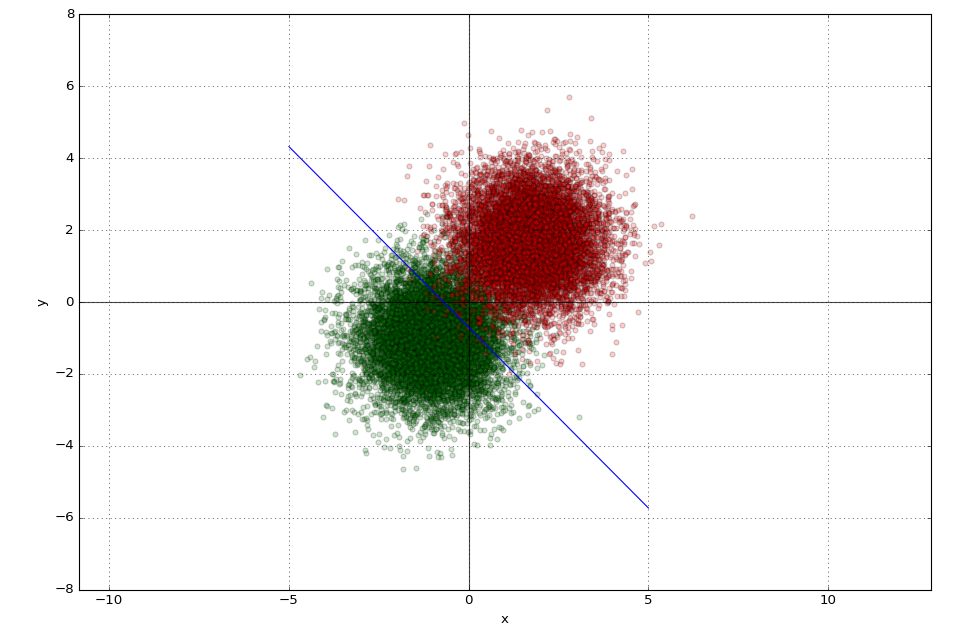

In [182]:
NUM_SAMPLES = 20000 #number of samples

first=np.random.normal(-1,1,(NUM_SAMPLES//2,2))
second=np.random.normal(1.7,1,(NUM_SAMPLES//2,2))

X=np.c_[np.ones(NUM_SAMPLES),np.concatenate((first,second))]
Y=np.r_[np.ones(NUM_SAMPLES//2),-np.ones(NUM_SAMPLES//2)].reshape(NUM_SAMPLES,1)

w_exact=np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

x_ax = np.linspace(-5, 5, 2)
y_ax_exact = np.array(w_exact[0]/w_exact[1]-(w_exact[2]/w_exact[1])*x_ax)

plot_setup()
plt.scatter(first.T[0],first.T[1],c='green',alpha=0.2)
plt.scatter(second.T[0],second.T[1],c='red',alpha=0.2)
plt.plot(x_ax, y_ax_exact.T, color='b')
plt.show()

Пункт 5. Две матрицы размеров $a\times b$ и $b \times c$ перемножаются за $O(abc)$ операций ($a\cdot c$ ячеек в новой таблице, на получение каждой требуется $b$ операций), матрица $a \times a$ оборачивается за $O(m^3)$ операций. Зная это, а также считая, что входная выборка имеет размер $n$ и $m$ параметров, получаем следующую асимптотику за счёт выполнения последовательно четырёх операций: умножения матриц $X_{m\times n}^T$ и $X_{n\times m}$, обращения получившейся матрицы $m\times m$, умножения обращённой матрицы $m\times m$ и $X_{m\times n}^T$ и умножения матриц $m\times n$ и $Y_{n \times 1}$. Тогда
$$O(m\cdot n \cdot m)+O(m^3)+O(m\cdot m \cdot n)+O(m\cdot n)=O(m^2n)+O(m^3).$$ Если считать, что $m<n$, то можно упростить выражение до $O(m^2n)$.

Еще популярна следующая релаксация
<center>$Q(w) = \frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}} max(0, 1 - y_i\cdot(wx_i + b))$,</center>
если хотите узнать об этом более подробно, то вам стоит почитать про svm (support vector machine).

Логистическая функция же обладает вероятностным смыслом

<center>$ Q(w) = \frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}} \ln(1 + \exp(-y_i\cdot(wx_i + b)))$</center>
В частности данный функционал приводит нас к оптимальному байесовскому классификатору при некоторых допущениях о распределении признаков. Но это совершенно отдельная история.

**Задание**

1. Пусть $\mathbb{P}\{y=1|x\} = \sigma(wx+b)$, где $\sigma(z) = \frac{1}{1 + \exp(-z)}$. Покажите, что задача
<center>$ \arg\min_{w, b} \sum_{x, y} \ln(1 + \exp(-y(wx + b)))$</center>
есть ничто иное, как максимазиция правдоподобия.
2. Отобразите все функционалы качества в осях $M \times Q$ для одного элемента.

1. Функция правдоподобия: $\mathbb{P}\{y|x\}=\sigma(y(wx+b))$. Если считать совпадения предсказанных классов для элементов выборки с актуальными классами независимыми в совокупности событиями, то можно переписать $\mathbb{P}\{y|x\}$ как $\prod_{i=0}^n\mathbb{P}\{y_i|x_i\}$. Максимизация функции правдоподобия тогда представляется как задача $$\underset{w}{\mathrm{argmax}}\prod_{i=0}^n\mathbb{P}\{y_i|x_i\}=\underset{w}{\mathrm{argmax}}\ln\prod_{i=0}^n\mathbb{P}\{y_i|x_i\}=$$ (исходя из монотонности логарифма, если функция в данной точке имеет максимум, то и её логарифм)$$=\underset{w}{\mathrm{argmax}}\sum_{i=0}^n\ln\mathbb{P}\{y_i|x_i\}=\underset{w}{\mathrm{argmax}}\sum_{i=0}^n\ln\sigma(y_i(wx_i+b))=\underset{w}{\mathrm{argmax}}\sum_{i=0}^n\ln(1+e^{-y(wx+b)})^{-1}=-\underset{w}{\mathrm{argmax}}\sum_{i=0}^n\ln(1+e^{-y(wx+b)})=$$(по свойству логарифма)$$=\underset{w}{\mathrm{argmin}}\sum_{i=0}^n\ln(1+e^{-y(wx+b)})$$

2. Так как $ M(x, y) = y\cdot(wx)$ (можно добавить первую компоненту к $x$, равную $1$ и к $w$, равную $b$ и получить исходное равенство), получаем следующие зависимости $Q$ от $M$:

    1) $Q = [y_{pred} \neq y_{true}]=[y\cdot(wx)<0]=[M < 0]$
    
    2) $Q = ((wx) - y)^{2}=\frac{1}{y^2}((wx\cdot y) - y^2)^2=\frac{1}{y^2}(M - y^2)^2$. Так как $y=\pm 1$, то $Q=(M - 1)^2$.
    
    3) $Q = max(0, 1 - y\cdot(wx))=max(0,1-M)$
    
    4) $Q = \ln(1 + e^{-y\cdot(wx)})=\ln(1+e^{-M})$

<IPython.core.display.Javascript object>


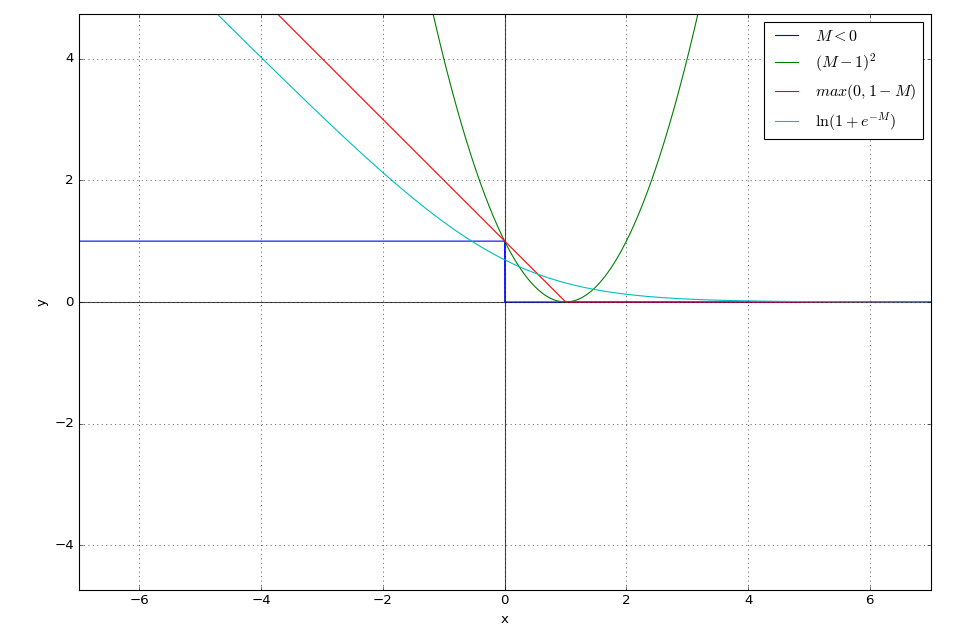

In [183]:
m=np.linspace(-7,7,1000000)

def exact_loss(x): return 1 if x<0 else 0
def mse_loss(x): return (x-1)**2
def hinge_loss(x): return max(0,1-x)
def logistic_loss(x): return np.log(1+np.exp(-x))

plot_setup()
plt.plot(m,list(map(exact_loss,m)),label='$M<0$')
plt.plot(m,list(map(mse_loss,m)),label='$(M - 1)^2$')
plt.plot(m,list(map(hinge_loss,m)),label='$max(0,1-M)$')
plt.plot(m,list(map(logistic_loss,m)),label='$\ln(1+e^{-M})$')
plt.legend(loc='best')
plt.xlim(-7,7)
plt.ylim(-3,3)
plt.show()

### 4. Градиентный спуск

Для задачи оптимизации не всегда существует аналитическое решение, либо оно может быть очень сложным. В таком случае используют численные методы. Да, речь идет именно о градиентном спуске. Это итеративный алгоритм, который устроен следующим образом. Пусть есть $Q(x)$, которую необходимо оптимизировать и она дифференцируема. Тогда задачу

<center>$ \arg\min_{x} Q(x)$</center>

можно решить следующим образом

<center>$ x^{k+1} = x^{k} - \lambda \cdot \triangledown Q(x)$,</center>

где $\lambda$ - некоторый шаг градиентного спуска, а $k$ - номер этого шага.

От выбора правильного $\lambda$ сильно зависит процесс обучения. Если взять слишком большое значение, то алгоритм может не сойтись. Если слишком малое, то обучение будет длиться долго. Также существует распространенный прием, применяемый часто при обучении нейросетей, уменьшать значение $\lambda$ в соответствии с некоторым расписанием.

**Задание**
1. Предложите какую-нибудь квадратичную функцию с глобальным минимумом.
2. Найдите минимум методом градиентного спуска.
3. Отобразите на плоскости линии уровней функции, которую вы оптимизируете.
4. Покажите, какую траекторию проходит алгоритм градиентного спуска.
5. Как вы выбрали значение $\lambda$?

<IPython.core.display.Javascript object>


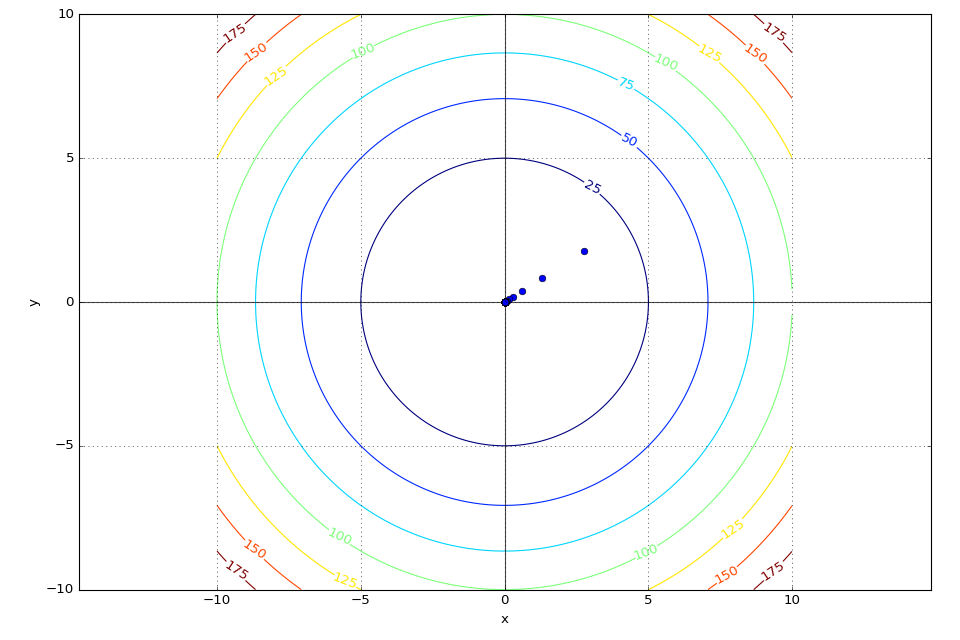

In [184]:
def simple_func(x,y):
    return x**2+y**2

def simple_grad(x):
    return 2*x

xx=np.arange(-10,10,0.01)
yy=np.arange(-10,10,0.01)
xgrid, ygrid = np.meshgrid(xx, yy)
zgrid=simple_func(xgrid,ygrid)
plot_setup()
cont=plt.contour(xgrid, ygrid, zgrid)
plt.xlim(-10,10)
plt.ylim(-10,10)
cont.clabel(fmt="%.0f")

def grad_descent_basic(w,func,grad,learning_rate,num_iters):
    steps=np.empty((num_iters,w.shape[0]))
    for i in range(num_iters):
        w = w - learning_rate*grad(w)
        steps[i,:]=w
    return w,steps

bestx_simple=np.random.rand(2)*10
bestval_simple=simple_func(bestx_simple[0],bestx_simple[1])
res_simple=bestx_simple
for lr in np.arange (0,1.5,1e-4):
    x_simple=np.random.rand(2)*10
    res=grad_descent_basic(x_simple,simple_func,simple_grad,lr,500)
    if simple_func(res[0][0],res[0][1])<bestval_simple:
        bestx_simple=x_simple
        bestval_simple=simple_func(res[0][0],res[0][1])
        res_simple=res[1]
        
plt.plot(res_simple.T[0],res_simple.T[1],'bo')
plt.show()

1. Функция $z=x^2+y^2$, глобальный минимум $0$ в точке $(0;0)$.
2. См. ячейку выше.
3. См. ячейку выше.
4. См. ячейку выше.
5. Перебирались все значения $\lambda$ от 0 до 1.5 (при больших значениях градиент в некоторых случаях начинает значительно возрастать) с шагом в $10^{-4}$, при этом оптимизировалось значение функции в найденной точке.

Существуют функции, которые плохо даются градиентному спуску. К примеру, функция Розенброка

<center>$f(x, y) = (1-x)^2 + 100(y-x^2)^2$.</center>

**Задание**
1. Проделайте все то же самое для функции Розенброка.
2. Какую проблему вы наблюдаете?
3. Как ее можно решить?

In [185]:
def rosenbrock(x,y):
    return (1-x)**2+100*(y-x**2)**2
def rosenbrock_grad(x):
    return np.array([-2*(1-x[1])-400*x[0]*(-x[0]**2+x[1]),200*(-x[0]**2+x[1])])
plt.figur
xx=np.arange(-20,20,0.1)
yy=np.arange(-20,20,0.1)
xgrid, ygrid = np.meshgrid(xx, yy)
zgrid=rosenbrock(xgrid,ygrid)
f=plot_setup()
ax=f.gca(projection='3d')
cont=ax.plot_surface(xgrid, ygrid, zgrid, norm=matplotlib.colors.LogNorm(),cmap=plt.cm.coolwarm,linewidth=0,shade=False)
f.colorbar(cont, shrink=0.5, aspect=5)
x=np.random.rand(2)*20
res_rosenbrock=grad_descent_basic(x,rosenbrock,rosenbrock_grad,1e-5,5000)[1]
z_ros=rosenbrock(res_rosenbrock.T[0],res_rosenbrock.T[1])
ax.plot(xs=res_rosenbrock.T[0],ys=res_rosenbrock.T[1],zs=z_ros)
f.show()

<IPython.core.display.Javascript object>

1. См. ячейку выше.

2. Можно заметить, что функция имеет участок с почти нулевым градиентом — «долину», но вне этой долины эта функция очень быстро растёт, поэтому при малых фиксированных $\lambda$ функция будет очень медленно сходиться, а при больших — расходиться, при этом градиент будет вновь быстро расти. Также в окрестности глобального минимума («долине») алгоритм будет двигаться в сторону глобального минимума очень медленно из-за близкого к нулю градиента.

3. Можно изменять скорость обучения динамически одним из множества способов, например, описанных ниже. Можно также стартовать алгоритм достаточно большое раз со случайными параметрами и затем выбрать лучший. Ещё есть вариант с нормализацией градиента (вообще говоря, длину также можно задавать), чтобы на каждой итерации мы двигались в направлении уменьшения функции, но одинаковыми шагами.

Существуют различные модификации алгоритма градиентного спуска. К примеру, метод наискорейшего спуска, где значение $\lambda$ зависит от шага

<center>$\lambda^{k} = \arg\min_{\lambda}Q(x_k - \lambda\triangledown Q(x_k))$.</center>

**Задание**
1. Снова разделите облака точек, только теперь оптимизируйте квадратичную ошибку метода градиентного спуска.
2. Отобразите полученную прямую и облака точек.
3. Сравните ответ с точным решением.
4. Попробуйте метод наискорейшего спуска.
5. Постройте график в осях (номер шага и значение $Q$).
6. Сравните скорость сходимости обычного и наискорейшего спуска.

In [187]:
def mse_loss(w,x,y):
    return (1/x.shape[0])*sum((x.dot(w)-y)**2)
def mse_grad(w,x,y):
    return (2/x.shape[0])*x.T.dot(x.dot(w)-y)

In [8]:
def grad_descent(w,x,y,func,grad,learning_rate,num_iters,accel=False):
    point=w.copy()
    costs=np.empty(num_iters)
    steps=np.empty((num_iters,w.shape[0]))
    for i in range(num_iters):
        q=func(point,x,y)
        costs[i]=q
        steps[i,:]=w.reshape(w.shape[0])
        g=grad(point,x,y)
        if accel:
            learning_rate=minimize(lambda l:func(point-l*g,x,y),x0=np.zeros((1,1))).x[0] #законом не запрещено
        point-=learning_rate*g
    return point,costs,steps

<IPython.core.display.Javascript object>


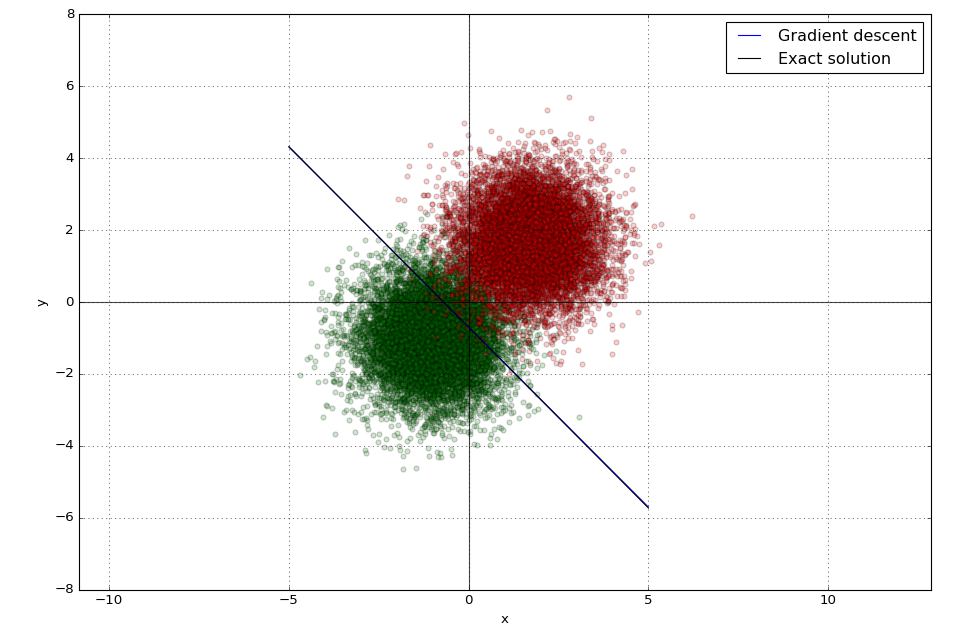

Difference between solutions norm: 0.0015635466336


In [188]:
w=np.random.rand(3,1)*10
w_mse=grad_descent(w,X,Y,mse_loss,mse_grad,0.01,300)
yy = np.array((w_mse[0][0]/w_mse[0][1])-(w_mse[0][2]/w_mse[0][1])*x_ax)
plot_setup()
plt.scatter(first.T[0],first.T[1],c='green',alpha=0.2)
plt.scatter(second.T[0],second.T[1],c='red',alpha=0.2)
plt.plot(x_ax, yy.T, color='b',label='Gradient descent')
plt.plot(x_ax, y_ax_exact.T, color='black',label='Exact solution')
plt.legend()
print('Difference between solutions norm:',np.linalg.norm(w_mse[0]-w_exact))
plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


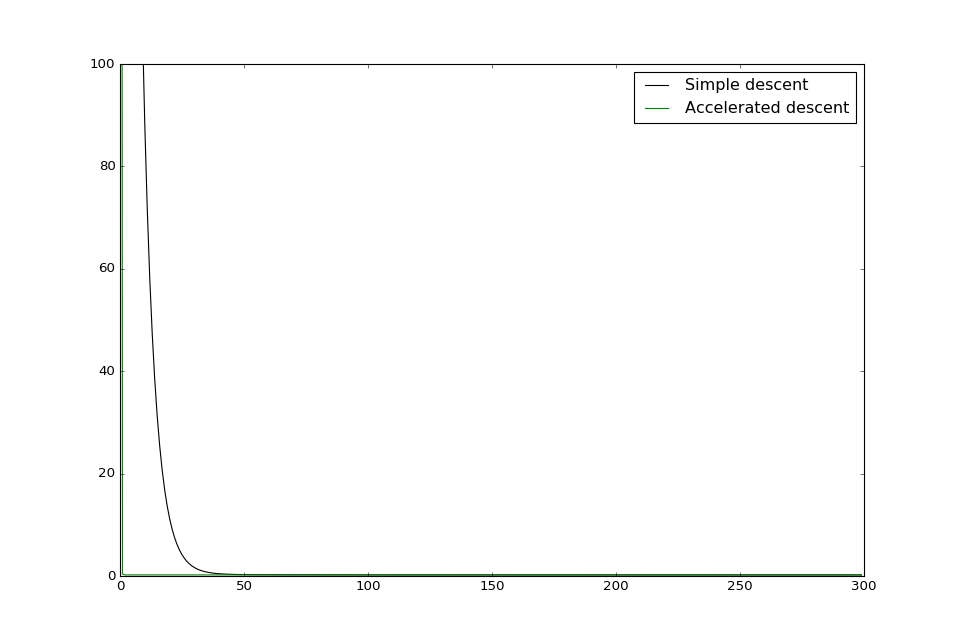

In [189]:
w_mse=grad_descent(w,X,Y,mse_loss,mse_grad,0.01,300)[1]
w_mse_accel=grad_descent(w,X,Y,mse_loss,mse_grad,0.01,300,accel=True)[1]
plt.figure()
plt.plot(w_mse.T,color='black',label='Simple descent')
plt.plot(w_mse_accel.T,color='green',label='Accelerated descent')
plt.legend()
plt.ylim(0,100)
plt.show()

И еще немного о проблемах градиентного спуска. Если у нас есть какие-то признаки, которые встречаются достаточно редко, то соответствующий столбец будет разряженным.

**Задание**
В чем заключается проблема?

Так как в данном столбце будут преобладать нули, то градиент по соответствующей переменной на фоне остальных будет довольно мал, что означает в случае малой скорости обучения потенциально очень низкую скорость схождения ответа к оптимальному по данной переменной, а в случае большой - шанс расхождения по неразреженным столбцам. 

Также нужно понимать, что градиентный спуск может попасть в "ловушку" локального минимума. Обычно это актуально для нейросетей. Самый простой способо решить эту проблема - сдедать несколько запусков алгоритма или иметь какой-то инсайд, из какой точки стоит начинать.

### 5. Стохастический градиентный спуск

Иногда количество данных может быть так велико, что даже градиентный спуск начинает работать медленно. Или же данные просто поступают к нам большим потоком, а параметры модели постепенно меняются. Тогда на сцену выходит метод стохастического градиента.

Идея пределельно проста. Можно делать шаг спуска, вычисляя ошибку и градиент не для всех элементов выборки, а для какого-то небольшого количества или даже для одного объекта.

**Задание**

1. Скачайте данные mnist c [Kaggle](https://www.kaggle.com/c/digit-recognizer).
2. Обучите линейный классификатор 0 и 1, используйте логистическую функцию потерь.
3. Проверьте качество классификации на отложенной выборке.
<center>$ \mathcal{L}(y_{pred}, y_{true}) = [y_{pred} \neq y_{true}]$ </center>
4. Как влияет размер батча на скорость и качество обучения?
5. Отобразите графики, которые доказывает ваши слова (оси придумайте сами).
6. Сколько проходов по данным вы делаете? Почему?


In [11]:
def logistic_loss(w,x,y):
    return (1/x.shape[0])*sum(np.log(1+np.exp(-y[i]*x[i].dot(w))) for i in range(x.shape[0]))

def logistic_grad(w,x,y):
    v=np.empty((x.shape[0],x.shape[1]))
    for i in range(x.shape[0]):
            v[i]=-y[i]*x[i]*(np.exp(-y[i]*x[i].dot(w))/(1+np.exp(-y[i]*x[i].dot(w))))
    return (1/x.shape[0])*np.sum(v,axis=0).reshape(x.shape[1],1)

In [12]:
def stoch_grad_descent(w,x,y,func,grad,learning_rate,num_passes,batch_size=x.shape[0]):
    opt=w.copy()
    num_batches=x.shape[0]//batch_size
    costs=np.empty(num_passes*num_batches)
    steps=np.empty((num_passes*num_batches,w.shape[0]))
    for p in range(num_passes):
        for j in range(num_batches):
            x_new=x[j*batch_size:(j+1)*batch_size]
            y_new=y[j*batch_size:(j+1)*batch_size]
            costs[p*num_batches+j]=func(opt,x_new,y_new)
            steps[p*num_batches+j,:]=opt.reshape(opt.shape[0])
            opt-=learning_rate*grad(opt,x_new,y_new)
    return opt,costs,steps

In [13]:
train=np.loadtxt('train.csv',skiprows=1,delimiter=',')
ones=train[train[:,0]==1]
zeroes=train[train[:,0]==0]
o_tr,o_test=np.split(ones,2)
z_tr,z_test=np.split(zeroes,2)
z_tr[:,0]=1
trainset=np.concatenate((o_tr,z_tr))
testset=np.concatenate((o_test,z_test))
labels=np.r_[np.ones(o_tr.shape[0]),-np.ones(z_tr.shape[0])].reshape(o_tr.shape[0]+z_tr.shape[0],1)
testset_labels=list(map(lambda x:1 if x==1 else -1,testset[:,0]))
testset[:,0]=1

In [14]:
start=np.zeros((train.shape[1],1))
sol=stoch_grad_descent(start,trainset,labels,logistic_loss,logistic_grad,1e-7,1000,batch_size=400)

In [15]:
def calculate_acc(w,test_features,test_labels):
    wrong=0
    preds=np.empty((test_features.shape[0],))
    for i in range(test_features.shape[0]):
        if(test_features[i].dot(w)>=0 and test_labels[i]==-1)or(test_features[i].dot(w)<0 and test_labels[i]==1):
            wrong+=1
    return wrong,1-wrong/testset.shape[0]

In [16]:
calculate_acc(sol[0],testset,testset_labels)

(8, 0.9981851179673321)

<IPython.core.display.Javascript object>


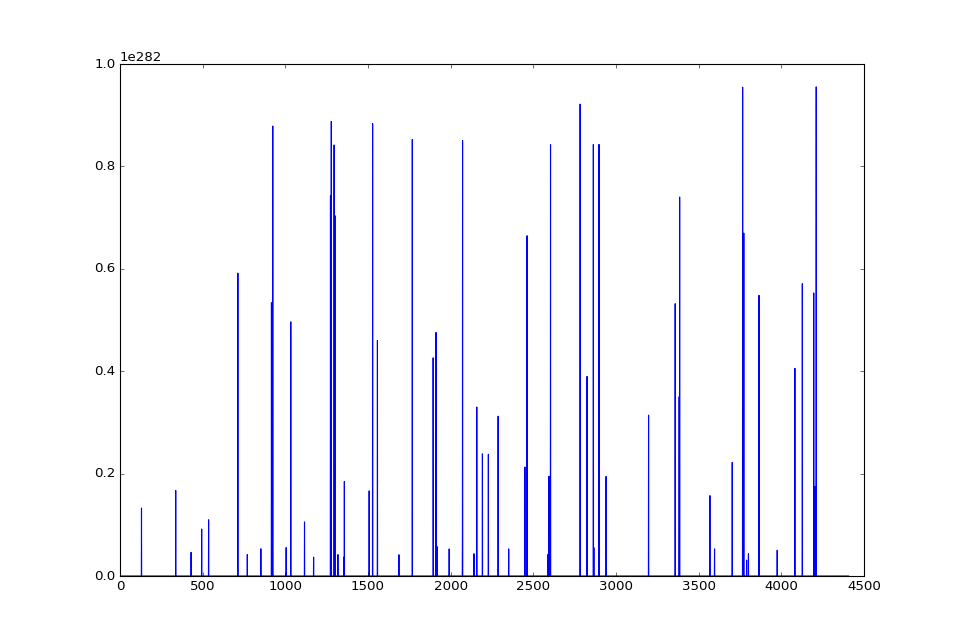

In [32]:
qual=np.empty((trainset.shape[0],1))
for i in range(10,trainset.shape[0],50):
    qual[i]=calculate_acc(stoch_grad_descent(start,trainset,labels,logistic_loss,logistic_grad,1e-7,10,batch_size=i)[0],testset,testset_labels)[0]
plt.figure()
plt.plot(qual)
plt.show()

<IPython.core.display.Javascript object>


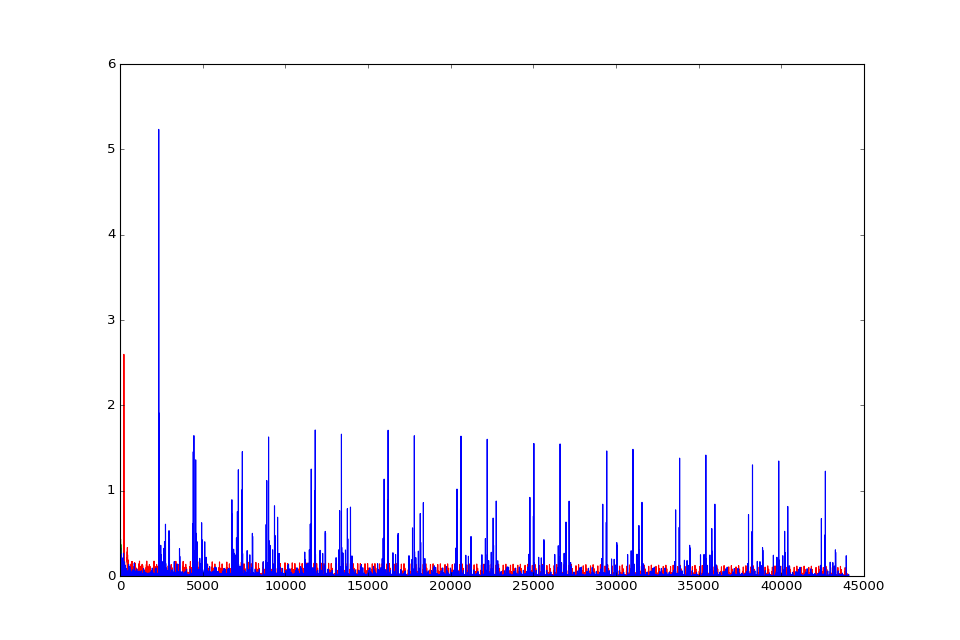

In [128]:
plt.figure()
plt.plot(stoch_grad_descent(start,trainset,labels,logistic_loss,logistic_grad,1e-7,4000,batch_size=400)[1],color='green')
plt.plot(stoch_grad_descent(start,trainset,labels,logistic_loss,logistic_grad,1e-7,100,batch_size=10)[1],color='red')
plt.plot(stoch_grad_descent(start,trainset,labels,logistic_loss,logistic_grad,1e-7,10,batch_size=1)[1],color='blue')
plt.show()

У стохастического градиентного спуска также есть много всяких усовершествований, которые часто используются в реальной практике при обучении нейросетей.

Кстати, текущее значение $Q$ можно вычислять с помощью экспоненциального сглаживания.
<center>$Q^{k+1} = \gamma Q^k + (1 - \gamma) Q(x_{k+1})$, </center>

где $Q(x_{k+1})$ вычисляется для обрабатываемого батча.

**Задание**
1. Как зависит график от $\gamma$?
2. Каким способом лучше вычислять $Q$?

In [33]:
def stoch_grad_descent_smooth(w,x,y,func,grad,learning_rate,num_passes,batch_size=x.shape[0],gamma=0):
    opt=w.copy()
    num_batches=x.shape[0]//batch_size
    costs=np.empty(num_passes*num_batches)
    steps=np.empty((num_passes*num_batches,w.shape[0]))
    for p in range(num_passes):
        for j in range(num_batches):
            x_new=x[j*batch_size:(j+1)*batch_size]
            y_new=y[j*batch_size:(j+1)*batch_size]
            if p+j!=0:
                costs[p*num_batches+j]=gamma*costs[p*num_batches+j-1]+(1-gamma)*func(opt,x_new,y_new)
            else:
                costs[p*num_batches+j]=func(opt,x_new,y_new)
            steps[p*num_batches+j,:]=opt.reshape(opt.shape[0])
            opt-=learning_rate*grad(opt,x_new,y_new)
    return opt,costs,steps

<IPython.core.display.Javascript object>


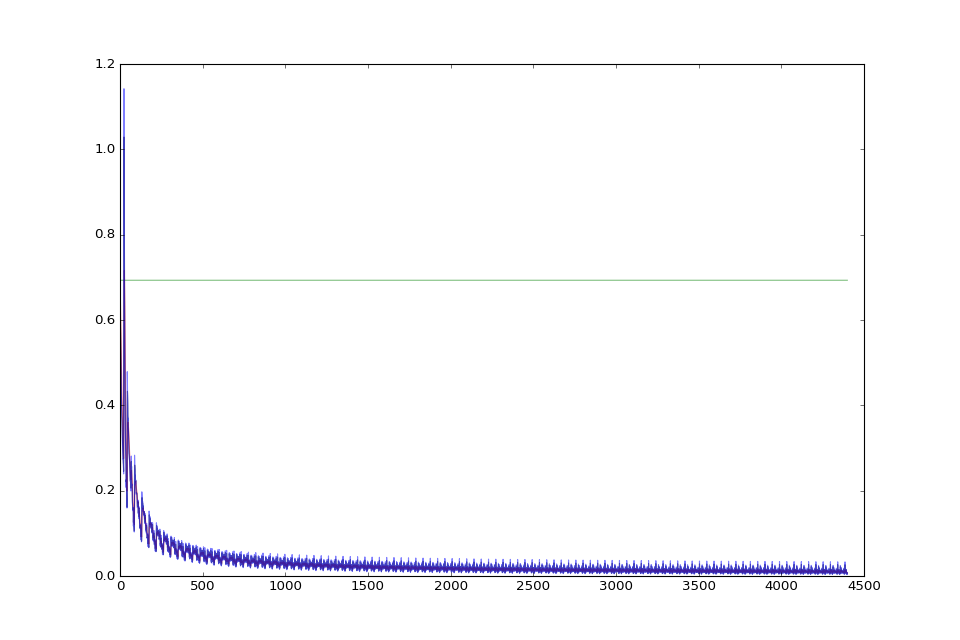

In [129]:
plt.figure()
plt.plot(stoch_grad_descent_smooth(start,trainset,labels,logistic_loss,logistic_grad,1e-7,100,batch_size=100,gamma=1)[1],color='green',alpha=0.5)
plt.plot(stoch_grad_descent_smooth(start,trainset,labels,logistic_loss,logistic_grad,1e-7,100,batch_size=100,gamma=0.75)[1],color='red',alpha=0.5)
plt.plot(stoch_grad_descent_smooth(start,trainset,labels,logistic_loss,logistic_grad,1e-7,100,batch_size=100,gamma=0.25)[1],color='black',alpha=0.5)
plt.plot(stoch_grad_descent_smooth(start,trainset,labels,logistic_loss,logistic_grad,1e-7,100,batch_size=100,gamma=0)[1],color='blue',alpha=0.5)
plt.show()

Заметим, что в случае $\gamma=1$ функция ошибки вырождается в константное значение на первом батче первого прохода, в случае $\gamma=0$ - в функцию ошибки без сглаживания. Также можно рассмотреть конкретные $Q^k$ и $Q(x_{k+1})$, тогда после несложных преобразований получаем, что $Q^{k+1}$ - линейная функция от $\gamma$, пересекающая ось ординат в точке $Q(x_{k+1})$. Таким образом, $\gamma$ влияет на график функции ошибки следующим образом: последующие значение начинают "учитывать" предыдущие, таким образом, как и следует из названия, сглаживаются скачки функции ошибки при обработке стоящих друг за другом батчей. Наиболее подходящий способ вычисления $Q$ зависит от задачи: сглаживание может не всегда удовлетворять нашим нуждам (например, мы хотим с какой-то целью анализировать скачки в неизменном виде). 

**Сохранение импульса**

Сохранения импульса позволяет избежать нам осциляции вдоль оси, по которой функция изменяется сильнее. Он заключается в том, что текущий градиентный шаг вычисляется на основе учета предыдущих шагов
<center> $x^{k+1} = x^{k} - s^{k}$,</center> где $s^k = \gamma s^{k-1} + \lambda\triangledown Q(x^k)$, при этом
 * $0 <\gamma < 1$ - коэффициент учета предыдущего импульса
 * $s^{-1} = 0$

**Задание**

1. Найдите минимум $Q(x, y) = 10x^2 + y^2$ c помощью обычного метода.
2. Воспользуйтесь методом сохранения импульса
3. Отобразите и сравните треки.
4. На основе чего вы выбрали $\gamma$?

<IPython.core.display.Javascript object>


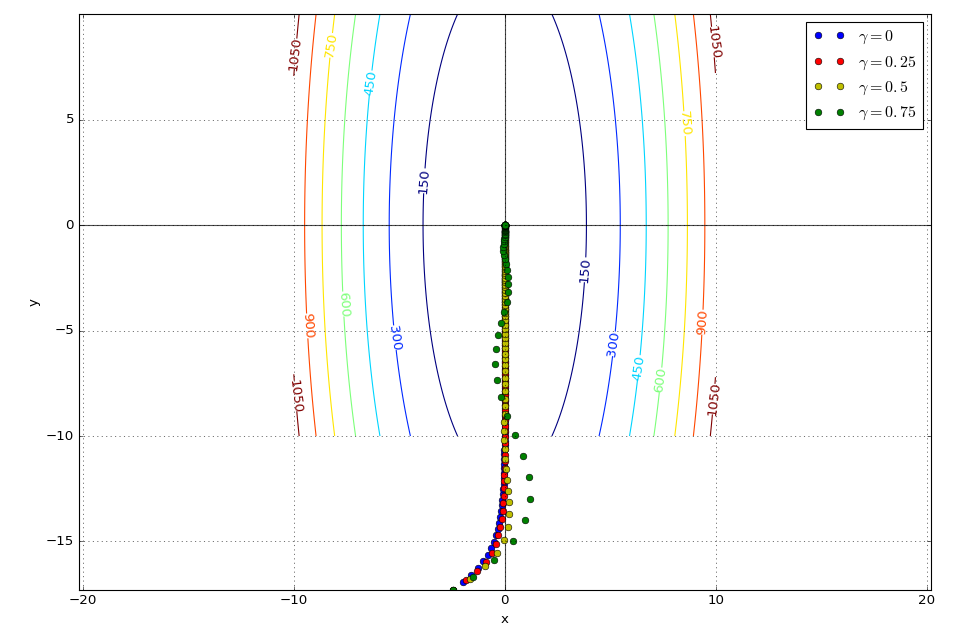

In [158]:
def simple_func_1(x,y):
    return 10*x**2+y**2

def simple_grad_1(x):
    return np.array([20*x[0],2*x[1]])

xx=np.arange(-10,10,0.01)
yy=np.arange(-10,10,0.01)
xgrid, ygrid = np.meshgrid(xx, yy)
zgrid=simple_func_1(xgrid,ygrid)
plot_setup()
cont=plt.contour(xgrid, ygrid, zgrid)
cont.clabel(fmt="%.0f")

def grad_descent_imp(w,func,grad,learning_rate,num_iters,gamma=0):
    steps=np.empty((num_iters,w.shape[0]))
    cur=w.copy()
    costs=np.empty((num_iters,1))
    impulses=np.empty((num_iters,w.shape[0]))
    impulses[0]=np.zeros(w.shape[0])
    for i in range(num_iters):
        costs[i]=func(cur[0],cur[1])
        if i>0:
            impulses[i]=gamma*impulses[i-1]+learning_rate*grad(cur)
        else:
            impulses[i]=learning_rate*grad(cur)
        cur -=impulses[i]
        steps[i,:]=cur
    return cur,steps,costs

x_simple_1=np.random.randn(2)*10
res_without_imp=grad_descent_imp(x_simple_1,simple_func_1,simple_grad_1,1e-2,100)
plt.plot(res_without_imp[1].T[0],res_without_imp[1].T[1],'bo',label='$\gamma=0$')
res_with_imp1=grad_descent_imp(x_simple_1,simple_func_1,simple_grad_1,1e-2,100,gamma=0.25)
plt.plot(res_with_imp1[1].T[0],res_with_imp1[1].T[1],'ro',label='$\gamma=0.25$')
res_with_imp2=grad_descent_imp(x_simple_1,simple_func_1,simple_grad_1,1e-2,100,gamma=0.5)
plt.plot(res_with_imp2[1].T[0],res_with_imp2[1].T[1],'yo',label='$\gamma=0.5$')
res_with_imp3=grad_descent_imp(x_simple_1,simple_func_1,simple_grad_1,1e-2,100,gamma=0.75)
plt.plot(res_with_imp3[1].T[0],res_with_imp3[1].T[1],'go',label='$\gamma=0.75$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


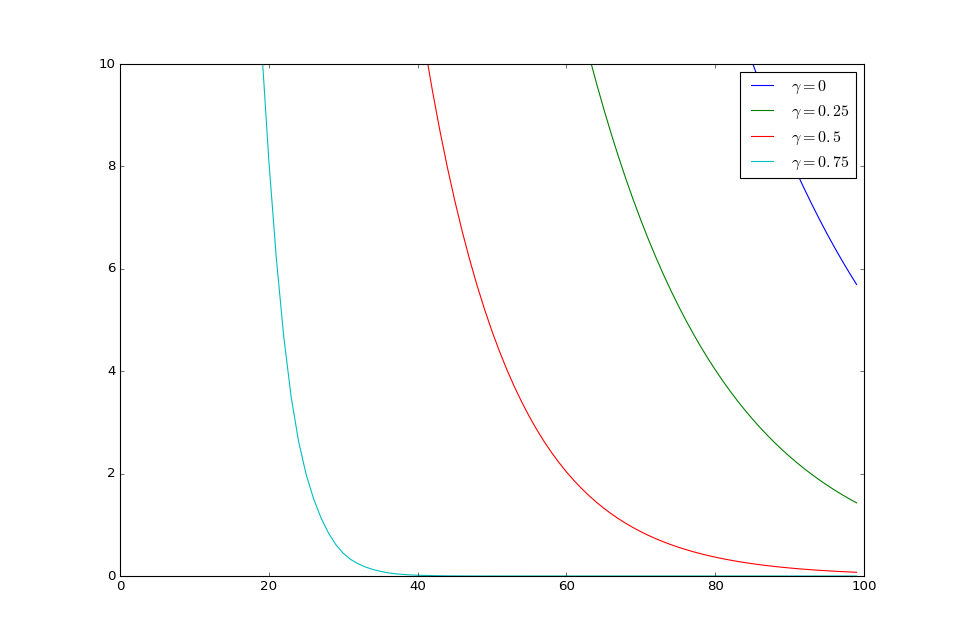

In [159]:
plt.figure()
plt.plot(res_without_imp[2],label='$\gamma=0$')
plt.plot(res_with_imp1[2],label='$\gamma=0.25$')
plt.plot(res_with_imp2[2],label='$\gamma=0.5$')
plt.plot(res_with_imp3[2],label='$\gamma=0.75$')
plt.ylim(0,10)
plt.legend()
plt.show()

Легко заметить, что повышение коэффициента даёт повышение скорости сходимости. Были рассмотрены 4 варианта $\gamma$, отстоящие от соседей на равных расстояниях, чтобы продемонстрировать динамику изменений графика в зависимости от данного параметра.

**Ускоренный градиент Нестерова**

И логическое развитие этого подхода приводит к методу ускоренного градиента Нестерова. Шаг спуска вычисляется немного иначе
<center>$s^k = \gamma s^{k-1} + \lambda\triangledown Q(x^k - s^{k-1})$,</center>
то есть мы вычисляем градиент фукнции примерно в той точке, куда "занесет" нас накопленный импульс.

<IPython.core.display.Javascript object>


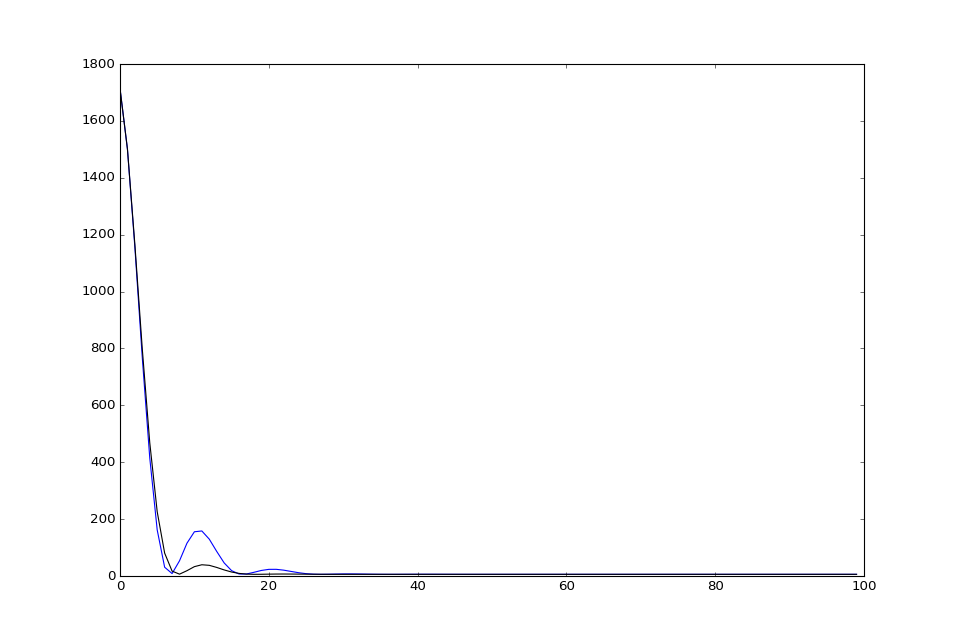

In [181]:
def grad_descent_nesterov(w,func,grad,learning_rate,num_iters,gamma=0):
    steps=np.empty((num_iters,w.shape[0]))
    cur=w.copy()
    costs=np.empty((num_iters,1))
    impulses=np.empty((num_iters,w.shape[0]))
    impulses[0]=np.zeros(w.shape[0])
    for i in range(num_iters):
        costs[i]=func(cur[0],cur[1])
        if i>0:
            impulses[i]=gamma*impulses[i-1]+learning_rate*grad(cur-impulses[i-1])
        else:
            impulses[i]=learning_rate*grad(cur)
        cur -=impulses[i]
        steps[i,:]=cur
    return cur,steps,costs

x=np.random.randn(2)*10
res_imp=grad_descent_imp(x,rosenbrock,rosenbrock_grad,1e-5,100,gamma=0.8)[2]
plt.figure()
plt.plot(res_imp)
res_nes=grad_descent_nesterov(x,rosenbrock,rosenbrock_grad,1e-5,100,gamma=0.8)[2]
plt.plot(res_nes,color='black')
plt.show()

**Задание**

1. Сравните этот метод и предыдущий на функции Розенброка.
2. Отобразите и сравните треки.

**Adagrad (2011)**

Адаптивный градиент подразумевает вычисление $\lambda$ для каждой размерности входного вектора $x$. Неформально говоря, для разряженных признаков он делает больший шаг, а для обычных шаг поменьше.
<center> $x_{i}^{k + 1} = x_{i}^{k} - \frac{\lambda}{\sqrt{G_{i, i}^k } + \varepsilon} \cdot \frac{\partial Q}{\partial x_i}(x^k)$, где 
</center>


* $G^{k} = \sum_{t=1}^{k}g_t g_t^{T}$, где $g_t = \triangledown Q(x^t)$.
* $\varepsilon$ - небольшая добавка, чтобы избежать деление на ноль.

Как ни странно это улучшает сходимость процесса обучение, к примеру, при работе нейросетей с текстами.

**Задание**

1. Обучите модель этим способом для mnist.
2. Сравните сходимость с обычным стохастическим градиентным спуском (графики).

**RMSprop**

Чтобы избежать постоянный рост знаменателя при $\lambda$ можно воспользоваться следующим вариантом шага. Давайте будем подсчитывать матрицу $G^k$ только для какого-то небольшого количества последних шагов, это можно сделать к примеру с помощью экспоненциального сглаживания

<center>$G^{k+1} = \gamma G^{k} + (1 - \gamma)g_{k+1}g_{k+1}^{T}$, где</center>
$0< \gamma < 1$ - чем больше значение, тем большее количество последних элементов мы учитываем.

**Adadelta (2012)**

**Задание**
1. Изучите метод самостоятельно и кратко опишите.
2. Как вы можете его объяснить?

**Adam (2015)**

**Задание**
1. Попробуйте скомбинировать метод сохранения импульса и RMSprop.
2. Получили ли вы какое-то улучшение?
3. Почему?

**Задание**
1. Предложите некоторую функцию, которая наглядно показываеn отличие в работе всех предложенных методов.
2. Сделайте анимацию, которая пошагово отрисовывает треки все спусков.